# Import required packages

In [29]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
#from tensorflow import keras
from keras import backend
from keras import regularizers, Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import Callback, EarlyStopping
from keras.optimizers import SGD, Adam
from keras.models import load_model, model_from_json
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import numpy as np
from numpy import ndarray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from cophi_toolbox import preprocessing
import pandas as pd
from hatesonar import Sonar
sonar = Sonar()
from collections import defaultdict
from operator import itemgetter
import bisect
import matplotlib.pyplot as plt
import pickle

from model import SiameseBiLSTM
from inputHandler import word_embed_meta_data, create_test_data
from config import siamese_config
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Lambda, \
    Bidirectional, TimeDistributed, Dropout, Conv1D, GlobalMaxPool1D
from keras.layers.merge import multiply, concatenate
import keras.backend as K
from util import make_w2v_embeddings, split_and_zero_padding, ManDist
import tensorflow as tf
import numpy as np
import re

In [30]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

# Train sentiment model with yelp data

In [31]:
data_path = 'yelp.csv'
data = pd.read_csv(data_path)
indx = data[(data.stars != 5)&(data.stars != 1)].index
data = data.drop(indx)
data = data.reset_index(drop=True)

In [32]:
max_length = 30
all_words = []
toxic_sentences = []
attitude_list = []
sentences_list = []
for i in range(len(data.index)):
    sentences = re.split(r'[.!]',data['text'][i].replace('\n',''))
    if data['stars'][i] ==1:
        attitude = 0
    elif data['stars'][i] ==5:
        attitude = 1
    for sentence in sentences:
        words = list(preprocessing.tokenize(sentence))
        if len(words) >= 3:
            all_words += words
            confid_score = sonar.ping(text=sentence)['classes'][1]['confidence']
            if  confid_score > 0.8:
                toxic_sentences.append(sentence)
            attitude_list.append(attitude)
            sentences_list.append(sentence)
encoder = LabelEncoder()
encoder.fit(all_words)
label_encoder_dict = defaultdict(LabelEncoder) 
for key, encoder in label_encoder_dict.items():
    classes = np.array(encoder.classes_).tolist()
    bisect.insort_left(classes, 'UNK')
    encoder.classes_ = classes
vocab_size = len(encoder.classes_)

In [33]:
toxic_df = pd.DataFrame(toxic_sentences,columns=['Toxic'])
toxic_df.to_csv('toxic.csv',index=False)

In [34]:
X_sentiment = []
for sentence in sentences_list:
    words = list(preprocessing.tokenize(sentence))
    if len(words) >= 3:
        try:
            words = words[:max_length]
        except:
            pass
        words_idx = np.array(encoder.transform(words))
        arr = np.full(max_length, 0)
        arr[:len(words)] = words_idx
        X_sentiment.append(arr)
X_sentiment = np.array(X_sentiment)
X_sentiment_label = np.array(attitude_list)

In [35]:
encoder_dict = {'encoder': encoder, 'X_sentiment': X_sentiment, 'X_sentiment_label': X_sentiment_label}
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.01, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
earlyStopping=EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
#model_toxic.add(GlobalAveragePooling1D())
model.add(Bidirectional(LSTM(50,dropout = 0.5, recurrent_dropout =0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy',f1_score])

In [38]:
history = model.fit(X_sentiment,
            X_sentiment_label,
            validation_split=0.1,
            callbacks=[earlyStopping],
            epochs=20,
            batch_size=64,
            class_weight = 'auto')

Train on 31059 samples, validate on 3451 samples
Epoch 1/20
31059/31059 [==============================] - 61s 2ms/step - loss: 0.5562 - acc: 0.7646 - f1_score: 0.8575 - val_loss: 0.5114 - val_acc: 0.7879 - val_f1_score: 0.8705
Epoch 2/20
31059/31059 [==============================] - 53s 2ms/step - loss: 0.5114 - acc: 0.7807 - f1_score: 0.8758 - val_loss: 0.4863 - val_acc: 0.7879 - val_f1_score: 0.8705
Epoch 3/20
31059/31059 [==============================] - 54s 2ms/step - loss: 0.4667 - acc: 0.7823 - f1_score: 0.8766 - val_loss: 0.4416 - val_acc: 0.7890 - val_f1_score: 0.8708
Epoch 4/20
31059/31059 [==============================] - 54s 2ms/step - loss: 0.4199 - acc: 0.8002 - f1_score: 0.8846 - val_loss: 0.4224 - val_acc: 0.8134 - val_f1_score: 0.8820
Epoch 5/20
31059/31059 [==============================] - 54s 2ms/step - loss: 0.3878 - acc: 0.8208 - f1_score: 0.8932 - val_loss: 0.4140 - val_acc: 0.8224 - val_f1_score: 0.8855
Epoch 6/20
31059/31059 [==============================] 

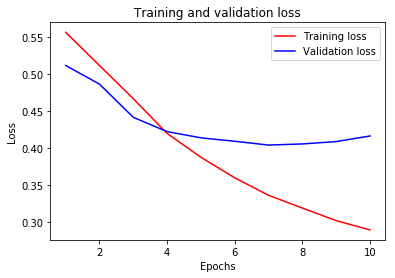

In [39]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

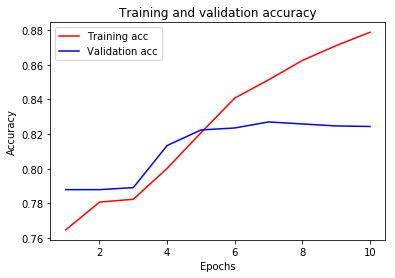

In [40]:
plt.clf()  
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
model_json = model.to_json()
with open("sentiment_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("sentiment_model.h5")

# Train similarity model with quora data

In [42]:
TRAIN_CSV = './quora_train.csv'
embedding_dim = 300
max_seq_length = 10
savepath = './en_SiameseLSTM.h5'


embedding_dict = {}

train_df = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

train_df, embeddings = make_w2v_embeddings(embedding_dict, train_df, embedding_dim=embedding_dim)

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)
X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)


Y_train = Y_train.values
Y_validation = Y_validation.values

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)



def shared_model(_input):

    embedded = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,),
                         trainable=False)(_input)

    activations = Bidirectional(LSTM(n_hidden, return_sequences=True, dropout = 0.2, recurrent_dropout =0.2), merge_mode='concat')(embedded)
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2), merge_mode='concat')(activations)

    # dropout
    #activations = Dropout(0.2)(activations)

    # Attention
    attention = TimeDistributed(Dense(1, activation='tanh'))(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(n_hidden * 2)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # dropout
    #sent_representation = Dropout(0.2)(sent_representation)

    return sent_representation

batch_size = 1024
n_epoch = 20
n_hidden = 50

left_input = Input(shape=(max_seq_length,), dtype='float32')
right_input = Input(shape=(max_seq_length,), dtype='float32')
left_sen_representation = shared_model(left_input)
right_sen_representation = shared_model(right_input)

man_distance = ManDist()([left_sen_representation, right_sen_representation])
sen_representation = concatenate([left_sen_representation, right_sen_representation, man_distance])
similarity = Dense(1, activation='sigmoid')(Dense(2)(Dense(4)(Dense(16)(sen_representation))))
model = Model(inputs=[left_input, right_input], outputs=[similarity])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_score])
model.summary()

history = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, callbacks=[earlyStopping], epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))
model.save(savepath)

50000 sentences embedded.
100000 sentences embedded.
150000 sentences embedded.
200000 sentences embedded.
250000 sentences embedded.
300000 sentences embedded.
350000 sentences embedded.
400000 sentences embedded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 10, 300)      25801800    input_3[0][0]                    
____________________________________________________________________________________________

Epoch 9/20
363861/363861 [==============================] - 162s 447us/step - loss: 0.4316 - acc: 0.7994 - f1_score: 0.7054 - val_loss: 0.4963 - val_acc: 0.7682 - val_f1_score: 0.6798
Epoch 10/20
363861/363861 [==============================] - 164s 451us/step - loss: 0.4242 - acc: 0.8037 - f1_score: 0.7131 - val_loss: 0.4935 - val_acc: 0.7704 - val_f1_score: 0.6809


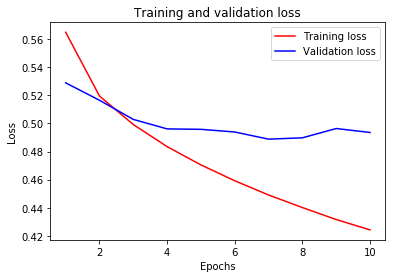

In [43]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

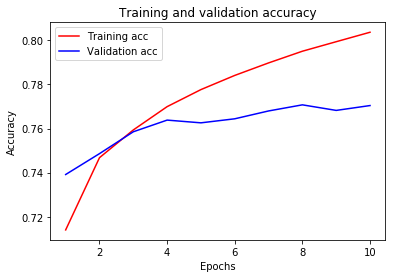

In [44]:
plt.clf()  
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
json_file = open('sentiment_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    loaded_model_sentiment = model_from_json(loaded_model_json)
    loaded_model_sentiment.load_weights('sentiment_model.h5')
with open('encoder.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
encoder=unserialized_data['encoder']

In [46]:
#senti should be 0 or 1, 0 is negative, 1 is positive
def compareSim(input_sentence,model,datapath,senti):
  
    
    #retrive reviews based on input sentiment
    if senti==0:
        datafile=datapath+'/yelp_0.txt'
    elif senti==1:
        datafile=datapath+'/yelp_1.txt'

    with open(datafile) as f:
        datayelp=f.readlines()

    #data cleaning 
    for i in range(len(datayelp)):
        datayelp[i] = datayelp[i].replace('.','').replace('\n','').replace('!','')

    # find the top 3 similar reviews
    result_index=[]
    test_sentence_pairs=[]
    for i in range(len(datayelp)):
        test_sentence=(input_sentence,datayelp[i])
        test_sentence_pairs.append(test_sentence)


    embedding_dict = {}

    test_df = pd.DataFrame(test_sentence_pairs, columns = ['question1','question2'])
    for q in ['question1', 'question2']:
        test_df[q + '_n'] = test_df[q]

    test_df, embeddings = make_w2v_embeddings(embedding_dict, test_df, embedding_dim=300)

    X_test = split_and_zero_padding(test_df, 10)

    assert X_test['left'].shape == X_test['right'].shape

    preds = list(model.predict([X_test['left'], X_test['right']]))

    results = [(x, y, z) for (x, y), z in zip(test_sentence_pairs, preds)]
    results.sort(key=itemgetter(2), reverse=True)


    return results[0:3]

In [47]:
def check_senti(input_sentence):
    words = list(preprocessing.tokenize(input_sentence))
    word_idx = np.array([encoder.transform(words)])
    
    if loaded_model_sentiment.predict_proba(word_idx)>0.6:
            senti = 1
    else:
            senti = 0

    return senti

def pred(input_sentence,model,datapath):
    
    class_value = sonar.ping(text=input_sentence)['top_class']
    if class_value == 'offensive_language':
        senti=check_senti(input_sentence)
        results=compareSim(input_sentence,model,datapath,senti)
    else:
        results='NO TOXIC'
    return results

In [48]:
# test 
modelpath='./en_SiameseLSTM.h5'
datapath='.'
model = load_model(modelpath, custom_objects={"ManDist": ManDist,'f1_score':f1_score})
input_sen='This place is fucking horrible'
print(check_senti(input_sen))
print(pred(input_sen,model,datapath))

0
[('This place is fucking horrible', 'the service was ok , not the best not the worst ', array([0.9927481], dtype=float32)), ('This place is fucking horrible', 'do not eat the pastries ', array([0.9705785], dtype=float32)), ('This place is fucking horrible', "it was thick and gooey and the flavor did n't wow ", array([0.9672185], dtype=float32))]
